In [1]:
import json

from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
from unidecode import unidecode

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity

In [2]:
# load tokenizer and model using bert romanian cased model
# https://github.com/dumitrescustefan/Romanian-Transformers
# https://huggingface.co/dumitrescustefan/bert-base-romanian-cased-v1

tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")
model = AutoModel.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")

Some weights of the model checkpoint at dumitrescustefan/bert-base-romanian-cased-v1 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# todo check diacritics encoding - all should be the same
docs = [
    
    # pizza
    {
        "title": "Pizza Exploziva",
        "description": "Sos de roșii, mozzarella, salam picant, gorgonzola, ceapă roșie, peperoncini",
        "category": "pizza",
    },
    
    {
        "title": "Margherita",
        "description": "Sos de roșii, mozzarella, grana padano, busuioc, ulei de măsline",
        "category": "pizza",
    },
    {
        "title": "Pizza Figo’s",
        "description": "Sos roșii, mozzarella, bacon, suncă, chipsuri, rucola",
        "category": "pizza",
    },
    {
        "title": "Pizza Prosciutto mică",
        "description": "Sos de roşii, mozzarella, șuncă",
        "category": "pizza",
    },
    {
        "title": "Pizza Znobiciosa Baby",
        "description": "Blat subțire și crocant , sos de roșii , mozzarella, prosciutto cotto, ciuperci champignon, măsline",
        "category": "pizza",
    },
    
    # paste
    {
        "title": "Spaghetti Carbonara (la vera ricetta)",
        "description": "Paste făcute în casă, Guanciale, chips de pancetta, tuille Parmigiano Reggiano, ouă - 320 g - O, L, DS, G, T, MU",
        "category": "paste",
    },
    {
        "title": "Spaghetti Bucatino alla Amatriciana",
        "description": "Ulei măsline , ceapă, usturoi, pancetta, busuioc, parmezan",
        "category": "paste",
    },
    {
        "title": "Quattro Formaggie",
        "description": "Paste de casă cu sos de brânzeturi ( mozzarela, gorgonzola, padano, cheddar ) 400 g",
        "category": "paste",
    },
    {
        "title": "Penne All’Almatriciana",
        "description": "Penne,; sos de roșii, bacon, ceapă, pătrunjel, usturoi, parmezan - 450 g",
        "category": "paste",
    }, 
    {
        "title": "Paste Polo e funghi",
        "description": "Penne, pui. \Ciuperci, smântână dulce, gorgonzola, busuioc, sare, piper, parmezan",
        "category": "paste",
    },
    
    # carti
    {
        "title": "Testamentele",
        "description": "Au trecut mai bine de cincisprezece ani de la evenimentele din Povestea Slujitoarei, iar regimul teocratic al Republicii Galaad inca tine fraiele puterii cu o mana de fier. Dar apar primele semne ca Galaadul incepe sa se erodeze din interior. Exact in acest moment de rascruce, vietile a trei femei complet diferite se intrepatrund in mod neasteptat. Urmarile pot fi dezastruoase sau pot duce la un viitor mai bun, dar cu siguranta vor cutremura zidurile lumii care le tine captive. Ramane de vazut daca aceste ziduri se vor si prabusi.In paginile Testamentelor Margaret Atwood ii deschide cititorului usa spre cele mai ascunse cotloane ale Galaadului pe masura ce fiecare personaj feminin din povestea ei e nevoit sa-si dea seama cine este de fapt si cat de departe ar merge pentru lucrurile in care crede.„Dragi cititori, toate intrebarile pe care mi le-ati pus despre Galaad si despre mecanismele lui au fost o sursa de inspiratie pentru aceasta carte. Sau aproape toate. Cealalta sursa de inspiratie a fost lumea in care traim.“ Margaret Atwood",
        "category": "book"
    },
    {
        "title": "Harry Potter si piatra filosofala",
        "description": "„Hogwarts va fi mereu aici sa-ti ureze bun-venit.“ J.K. Rowling„Cartile Harry Potter au o calitate rar intalnita: sunt adorate de parinti si de copii deopotriva.“ Daily Telegraph„Aventurile lui Harry Potter sunt la fel de amuzante ca povestile lui Roald Dahl si la fel de pline de viata ca volumele seriei Narnia.“ Daily Mail„J.K. Rowling a format o intreaga generatie de cititori.“ The Times„Daca in copilarie as fi avut acces la cartile cu Harry Potter, sunt convins ca nu doar copilaria, ci si tineretea, maturitatea si batranetea mea ar fi aratat altfel.“ Florin Bican, traducator in limba romana al primului volum din seria Harry Potter",
        "category": "book"
    },
    {
        "title": "Institutul",
        "description": "Bestseller New York TimesLa miezul noptii, intr-o casa de pe o strada linistita din suburbiile orasului Minneapolis, parintii lui Luke Ellis sunt omorati si el e aruncat intr-o masina. Totul, in mai putin de doua minute.Luke se trezeste la Institut, intr-o camera foarte asemanatoare cu cea din casa lui, insa fara ferestre. Dincolo de usi sunt alte usi. Dincolo de usi sunt alti copii cu talente speciale, care au ajuns acolo la fel ca el.In aceasta institutie sinistra, directorul urmareste sa amplifice puterile supranaturale ale copiilor, ca ei sa devina arme guvernamentale. Pe masura ce tot mai multi dispar, Luke isi da seama ca trebuie sa evadeze.Dar nimeni nu a scapat vreodata din Institut.„King ne uimeste cu cea mai inspaimantatoare poveste despre copii care se confrunta cu raul de la IT incoace. Intrand in mintea personajelor-copii, King reda amenintarea si intimitatea fricii cu o intensitate extraordinara.“Publishers Weekly„Cum ajunge o fiinta umana sa priveasca abuzul asupra copiilor mai intai ca pe un rau necesar, apoi ca pe o rutina? King ridica aceasta problema cu relevanta politica de neocolit pentru lumea de azi.“The New York Times",
        "category": "book"
    },
    {
        "title": "Zece negri mititei",
        "description": "„Zece...“ Zece straini sunt atrasi de un misterios U.N. Owen, intr-o casa de pe o insula izolata, din apropierea Devonului.„Noua...“ In timpul cinei, un mesaj inregistrat ii acuza pe fiecare in parte de cate o crima, iar in final, in aceeasi seara, unul dintre oaspeti moare.„Opt...“ Rupti de lume din cauza unei furtuni violente si urmariti de versurile unei vechi poezii pentru copii, care numara descrescator de la zece la zero, oaspetii lui U.N. Owen incep, unul cate unul, sa moara.„Sapte...“ Care dintre ei este criminalul? Oare va supravietui cineva?Agatha Christie este cunoscuta in intreaga lume drept „Regina Crimei“. Hercule Poirot, cel mai celebru detectiv din romanele politiste de la Sherlock Holmes, a fost creat pentru primul roman alAgathei Christie, Misterioasa afacere de la Styles. Poirot si Miss Marple au devenit faimosi la nivel mondial si au facut subiectul multor filme realizate pentru marele si micul ecran.",
        "category": "book"
    },
    {
        "title":"Fahrenheit 451",
        "description": "O poveste tulburatoare si poetica, Fahrenheit 451 este o parabola a unei societati in care valorile pe care le cunoastem au fost rasturnate, in care statul interzice cititul si legifereaza arderea cartilor. Cetatenii acestei lumi distopice traiesc intr-o indiferenta indusa de droguri si de mass-media. Unul dintre ei este Guy Montag. El are o sarcina simpla: trebuie sa dea foc tuturor cartilor si caselor in care acestea sunt ascunse. Ii place meseria pe care-o practica de zece ani, simte ca-si face pe deplin datoria si nu are niciodata indoieli... pana in momentul in care o adolescenta ii povesteste despre un trecut in care oamenilor nu le era teama. La fel de proaspat si parca mai relevant acum, la peste o jumatate de secol de la aparitie, acest roman-cult reuseste performanta de a fi deopotriva o capodopera a literaturii universale, un clasic al genului si un best-seller.",
        "category": "book"
    },

    # dipers
    {
        "title": "Scutece Huggies Elite Soft 2 4-6 kg, 80 buc",
        "description": """Scutece Huggies Elite Soft 2 4-6 kg, 80 buc


            Pentru nou-nascuti

            Scutece Huggies Elite Soft sunt special concepute pentru nou-nascuti. Atat in interior, cat si exterior contin materiale foarte moi, pentru pielea delicata a bebelusului.


            Pernute absorbante moi

            Pernutele moi ale stratului interior creeaza o bariera delicata intre pielea bebelusului si scaunul lichid. Materialele moi din stratul exterior al scutecului actioneaza delicat asupra pielii bebelusului, ca imbratisarea mamei. Microporii, care permit pielii sa "respire", asigura o circulatie a aerului in interiorul scutecului, impiedica aparitia dermatitei intertriginoase.


            Canalele de absorbtie reduc atirnarea scutecului

            Stratul interior inovator SoftAbsorb absoarbe lichidul si scaunul lichid in cateva secunde, contribuind la pastrarea pielii bebelusului uscate cat mai mult posibil.


            Buzunar interior impotriva scurgerilor

            Huggies Elite Soft are un brau elastic, pentru ca scutecul sa adereze bine la corp, insa sa nu stranga prea tare burtica si sa nu frece pielea delicata a copilului. Buzunarul interior de pe brau previne scurgerea scaunului lichid pe spinare.


            Indicator de umiditate

            Indicatorul special isi schimba culoarea atunci cand scutecul devine umed - ca sa puteti usor determina cand scutecul trebuie schimbat.


            Cea mai blanda protectie a noastra, ca imbratisarea mamei

            Caracteristicile scutecelor Huggies Elite Soft:

            Stratul interior inovator SoftAbsorb absoarbe lichidul in cateva secunde.
            Pernutele deosebit de moi ale stratului interior creeaza o bariera delicata intre pielea bebelusului si scaunul lichid.
            Materialele poroase permit pielii sa "respire”.
            Braul moale super elastic pentru o aderare perfecta.
            Buzunarul interior special ajuta la prevenirea scurgerii pe spinare.
            Indicatorul de umiditate va sopteste cand scutecul trebuie schimbat.
            Huggies Elite Soft pentru nou-nascuti este cea mai delicata protectie * ca imbratisarea mamei!

            * in comparatie cu versiunile anterioare ale scutecelor, Huggies Newborn.""",
        "category": "dipers",
    },
        {
        "title": "Scutece Pampers Premium Care Mega Box Marimea 5, 11-16 kg, 88 buc",
        "description": """Scutece Pampers Premium Care Mega Box Marimea 5, 11-16 kg, 88 buc

            Pentru o protectie ideala a pielii bebelusului.


            *Conform datelor Nielsen, cota de piata pentru marimile 0 si 1 (perioada mai 2019 – iunie 2020).


            Strat superior delicat


            Stratul superior Pampers permite patrunderea aerului si ofera confort pielii bebelusului tau, prevenind iritatiile pielii.


            Strat extern din material care respira


            Aerul se misca liber, ajutand sa mentina uscata pielea bebelusului.


            Aripioare laterale mai moi


            Aripioarele laterale moi se adapteaza delicat burticii bebelusului si ofera confort pielii.


            Forma care protejeaza zona ombilicala


            Forma care protejeaza burtica delicata a nou-nascutului.


            Nucleu absorbant foarte puternic


            Nucleul absorbant puternic absoarbe lichidul instantaneu si mentine pielea bebelusului uscata si protejata timp de pana la 12 ore.


            Indicator de umezeala


            Scutecele au un indicator de umezeala, care devine albastru si iti arata cand bebe trebuie schimbat.


            Mansete duble moi


            Mansetele duble se muleaza delicat pe picioruse si protejeaza impotriva scurgerilor.


            Testate dermatologic


            Conceput pentru a fi delicat cu pielea bebelusuui tau.


            OEKO_TEX®


            Certificat de Oeko-tex® standard 100. Pentru asigurarea calitatii de care fiecare parinte are nevoie.


            Testat dermatologic


            Certificat de Oeko-tex® standard 100. Pentru asigurarea calitatii de care fiecare parinte are nevoie. Fara cei 26 de alergeni ai UE.
        """,
        "category": "dipers",
    },
        {
        "title": "Servetele umede Pampers Sensitive, 6 pachete x 52, 312 buc",
        "description": """Servetele umede Pampers Sensitive, 6 pachete x 52, 312 buc

            Curatare delicata pentru pielea sensibila cu servetelele Pampers Sensitive

            Pielea sensibila a bebelusului tau este delicata si merita o curatare blanda, incepand cu schimbarea scutecului. Servetelele umede Pampers Sensitive ofera o curatare mai delicata si mai eficienta (fata de produsul anterior) pentru a ingriji pielea sensibila a bebelusului tau in cel mai eficient mod posibil, datorita materialului lor mai moale si mai dens. Enzimele din urina si scaun modifica Ph-ul pielii, crescand riscul de iritatii si eruptii cutanate. Serevtele Pampers Sensitive contin o formula unica care protejeaza Ph-ul natural al pielii mai bine decat bumbacul si apa, astfel incat si pielea cea mai sensibila este curata si protejata impotriva iritatiei pielii.


            Protejeaza pH-ul natural al pielii

            Formula lor unica pe baza de apa protejeaza pH-ul natural al pielii mai bine decat bumbacul si apa.


            Concepute avand in vedere pielea delicata a bebelusului

            Servetelele Pampers contin 0% alcool, coloranti si parfum.


            Aprobate de Alianta pentru sanatatea Pielii

            Sunt testate dermatologic si sunt potrivite pentru pielea sensibila a nou-nascutilor.


            Fabricat cu fibre din plante

            O tesatura mai moale si mai densa* (*fata de produsul anterior) curata chiar mai bine decat inainte.""",
        "category": "dipers",
    },
        {
        "title": "Servetele umede Huggies Natural Care, 10 pachete x 56, 560 buc",
        "description": """Nu contin alcool si parabeni. 3 straturi groase, moi, absorbante. Fibre naturale. Fara ''efect lipicios''. 
             Fibre naturale prietenoase cu pielea; 65% celuloza.""",
        "category": "dipers",
    },
        {
        "title": "Cearceaf absorbant Happy, 90x60 cm, 10 buc.",
        "description": """Cearceaf absorbant Happy, 90x60 cm, 10 buc. 
             Cearceaful absorbant Happy este ideal pentru momentul cand schimbati scutecul bebelusului, in special in timpul calatoriilor sau super-protectie pentru asternuturile patului copilului. Dimensiune : 90 x 60 cm Pachetul contine 10 bucati .""",
        "category": "dipers",
    }
    
]


with open('docs.json', 'w') as fout:
    json.dump(docs , fout)


data=pd.read_json("docs.json")

In [4]:
stopwords = np.loadtxt("romanian_stopwords.txt", dtype=str)
def preprocess(tokens):
    new_tokens = []
    tokens = unidecode(tokens)
    for token in tokens.split():
        token = token.lower()
        if token in stopwords:
            continue
        token = ''.join(c if c.isalpha() else ' ' for c in token)
        if token:
            new_tokens.append(token.strip())
    return " ".join(new_tokens)


data["clean_description"] = data.description.apply(preprocess)
data["category_text"] = data.category.apply(lambda s : "documentul are categoria {}.".format(s))
data["title_text"] = data.title.apply(lambda s : "documentul are titlul {}.".format(s))

data["clean_description2"] = data["title_text"] + " " + data["clean_description"] + " " + data["category_text"]
data["clean_description3"] = data["title_text"] + " [SEP ]" + data["clean_description"] + " [SEP] " + data["category_text"]


In [5]:
def create_embeddings(model, data):
    embeddings = []
    for doc in data:
        _tokens = tokenizer.encode(doc, add_special_tokens=True, return_tensors="pt")
#         for k in _tokens:
#             print(tokenizer.decode(k))
        _tokens_embeddings = model(_tokens)[0]
        _tokens_embeddings_mean = np.mean(_tokens_embeddings.detach().numpy().squeeze(), axis=0)
        embeddings.append(_tokens_embeddings_mean)
    embeddings = np.array(embeddings)
    return embeddings

In [6]:
embeddings = create_embeddings(model, data.description)
clean_embeddings = create_embeddings(model, data.clean_description)
clean_embeddings2 = create_embeddings(model, data.clean_description2)
clean_embeddings3 = create_embeddings(model, data.clean_description3)

In [7]:
def get_similarity_matrix(embeddings, metric=cosine_distances):
    x = pd.DataFrame(metric(embeddings, embeddings))    
    x =x.round(decimals=2)
    
    mask = np.triu(x.corr())
    mask = None

    fig, ax = pyplot.subplots(figsize=(15,15))
    ax.hlines([3, 6, 9], *ax.get_xlim())

    cmap = sns.cm.rocket_r
    sns.heatmap(x, linewidth=0.5, annot=True, ax=ax, cmap=cmap, mask=mask)
    
    return x

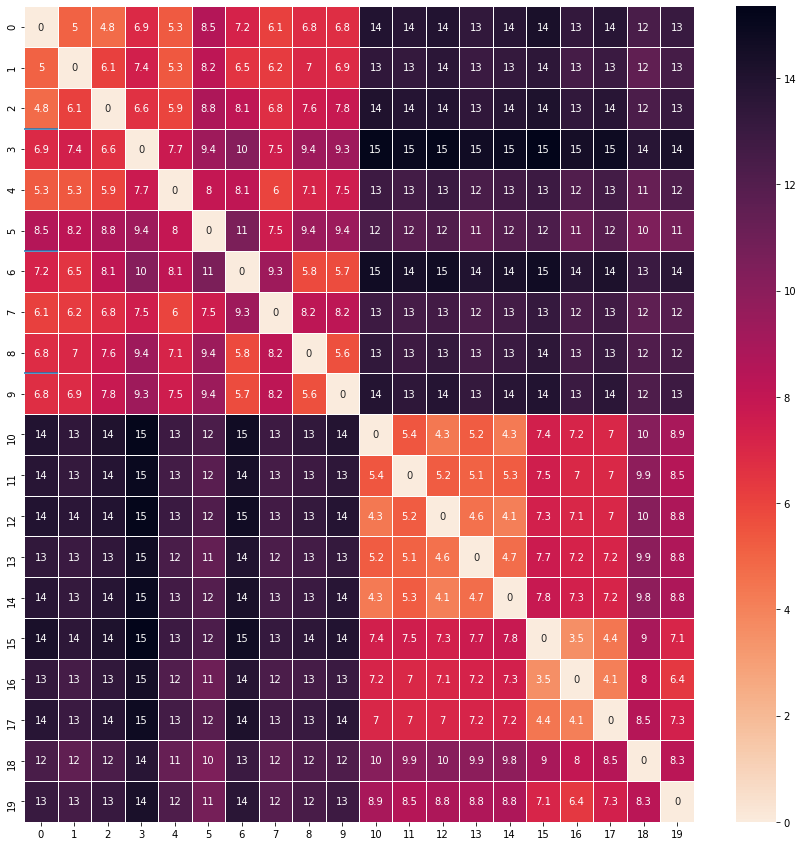

In [8]:
m = get_similarity_matrix(embeddings, euclidean_distances)

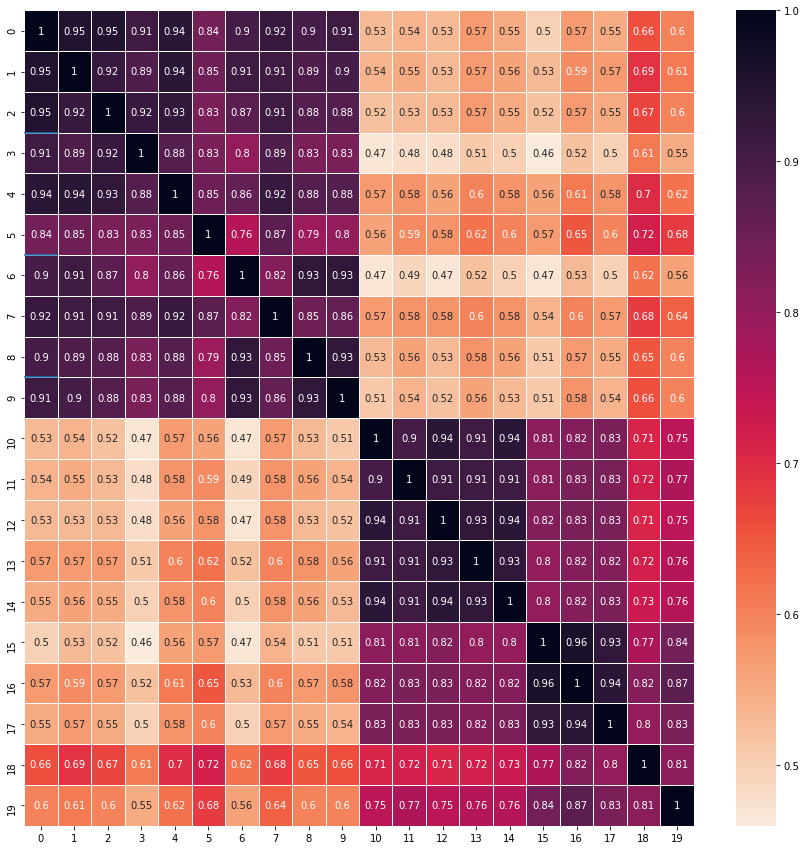

In [9]:
m = get_similarity_matrix(embeddings, cosine_similarity)

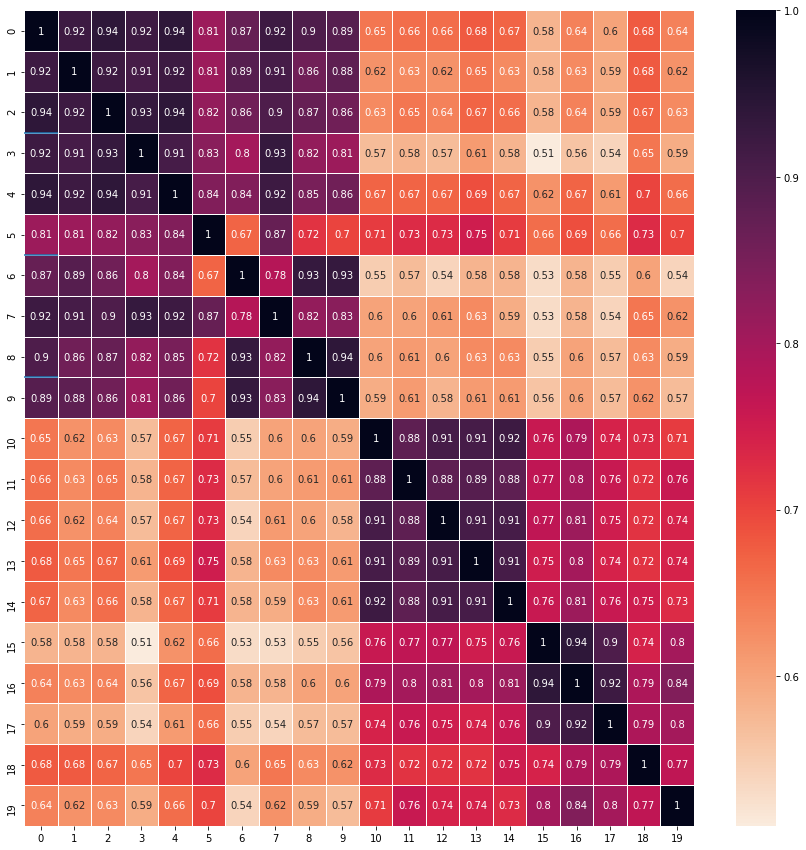

In [10]:
m = get_similarity_matrix(clean_embeddings, cosine_similarity)

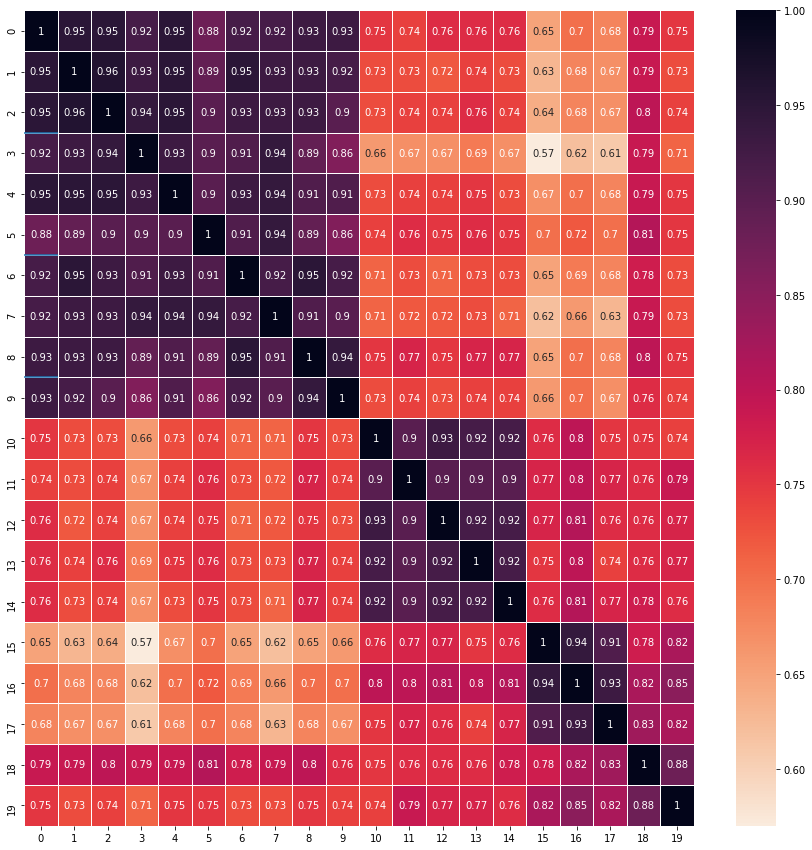

In [11]:
m = get_similarity_matrix(clean_embeddings2, cosine_similarity)

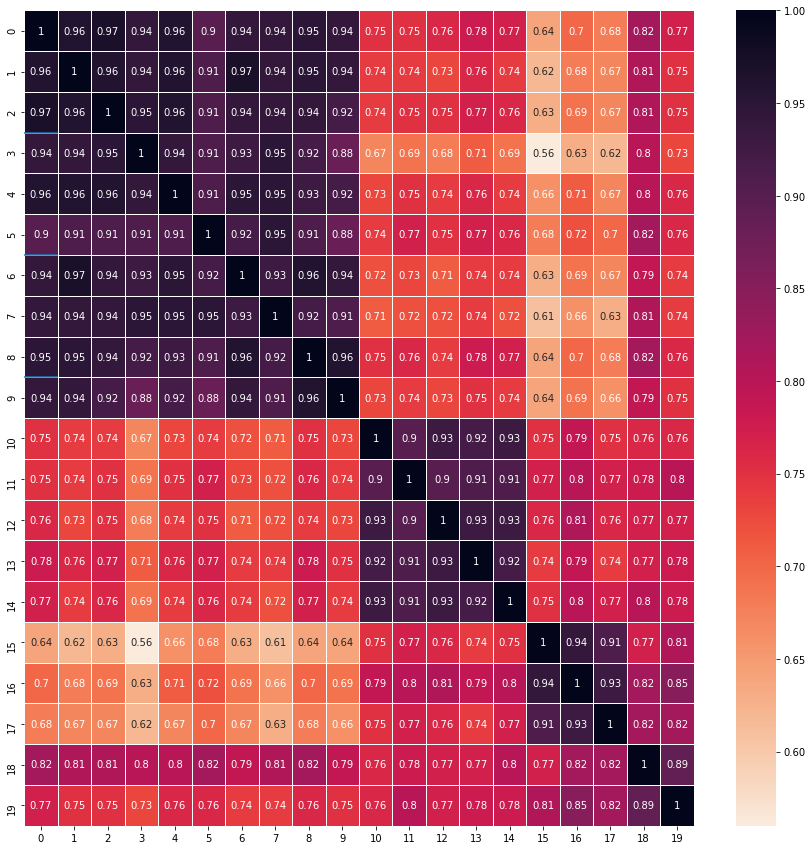

In [12]:
m = get_similarity_matrix(clean_embeddings3, cosine_similarity)